In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import heapq

### Adjacency matrix for grid

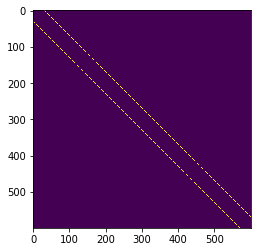

In [2]:
def grid_adj_mat(I, J, connectivity="4"):
    '''Generates an adjacency matrix repesenting a grid.
    
    NOTE: Assumes 8-directional connections, and that the
    grid origo is in the top-left corner.
    
    Args:
        I (int): Row count
        J (int): Col count 
        connectivity (str): Four- or eight-directional grid connectivity.
    '''
    # Number of elements
    n = I * J
    A = np.zeros((n, n), dtype=np.int8)
    
    diag_block = np.zeros((J, J), dtype=np.int8)
    for idx in range(J-1):
        diag_block[idx, idx+1] = 1
        diag_block[idx+1, idx] = 1
    
    if connectivity == "4":
        side_block = np.eye(J, dtype=np.int8)
    elif connectivity == "8":
        side_block = np.eye(J, dtype=np.int8) + diag_block
    else:
        raise Exception("Undefined connectivity")
    
    # First block row
    if I == 1:
        A[0:J, 0:J] = diag_block
    else:
        A[0:J, 0:J] = diag_block
        A[0:J, J:2*J] = side_block
        
        # Last block row
        A[-1*J:, -2*J:-1*J] = side_block
        A[-1*J:, -1*J:] = diag_block
    
    # Middle block rows
    for idx in range(1,I-1):
        i_start = idx*J
        i_end = (idx+1)*J
        A[i_start:i_end, (idx-1)*J:(idx+0)*J] = side_block
        A[i_start:i_end, (idx+0)*J:(idx+1)*J] = diag_block
        A[i_start:i_end, (idx+1)*J:(idx+2)*J] = side_block
    
    return A

# Grid dimension
I = 20
J = 30
A = grid_adj_mat(I, J, "4")
plt.imshow(A)
plt.show()

In [3]:
def get_neighbor_nodes(node_idx, A):
    '''Returns a list of node indices corresponing to neighbors of given node.
    '''
    return np.nonzero(A[node_idx, :])[0]

In [4]:
def weighted_adj_matrix(A, W_dense):
    '''Generates edge weights according to a dense cost map.
    '''
    
    A_weights = np.zeros(A.shape)
    
    # Col count
    J = W_dense.shape[1]
    
    # Extract coordinates of non-zero cost as 1D arrays
    elem_coord = np.nonzero(W_dense)
    i_coord = elem_coord[0]
    j_coord = elem_coord[1]
    
    elem_N = i_coord.shape[0]
    
    # Add edge weights one weight element at a time
    for idx in range(elem_N):
        # Coordinate of current weight element
        i = i_coord[idx]
        j = j_coord[idx]
        
        # Weight element position in A matrix
        elem_idx = J*i + j
        
        # Get connected neighbor
        neigh_idxs = get_neighbor_nodes(elem_idx, A).tolist()
        
        # Add weight to neighbor -> weight element
        for neigh_idx in neigh_idxs:
            A_weights[neigh_idx, elem_idx] = W_dense[i, j]
        
    return A_weights
    
    
W = np.zeros((I,J))
W[0,2] = 10.0
W[1,2] = 10.0

#plt.imshow(W)
#plt.show()

A_weights = weighted_adj_matrix(A, W)

print(A_weights)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 10. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


### Graph representation

Graph is defined by an Adjacency matrix A, and an edge Weight matrix W.
Number of nodes corresond to rows in A.

Node properties are accessed from a 1D array

- d[node_idx] : Distance from starting node
- par[node_idx] : Parent idx in shortest path

In [5]:
def initialize_single_source(node_N, start_node_idx):
    d = np.inf * np.ones(node_N)
    par = -1*np.ones(node_N)
    
    d[start_node_idx] = 0.0
    
    d = d.tolist()
    par = par.tolist()
    
    return d, par

In [6]:
def relax(u, v, W, d, par):
    if d[v] > d[u] + W[u,v]:
        d[v] = d[u] + W[u,v]
        par[v] = u
    return d, par

In [7]:
def dijkstra(A, A_weights, start_node_idx):
    node_N = A.shape[0]
    
    d, par = initialize_single_source(node_N, start_node_idx)
      
    S = set()
    Q = {}
    for idx in range(node_N):
        Q[idx] = d[idx]
    
    while len(Q) > 0:
        
        u = min(Q, key=Q.get)
        Q.pop(u)
        S.add(u)
        
        neigh_set = get_neighbor_nodes(u, A).tolist()
        
        for v in neigh_set:
            if v in S:
                continue
            d, par = relax(u, v, A_weights, d, par)
            Q[v] = d[v]
    
    return d, par

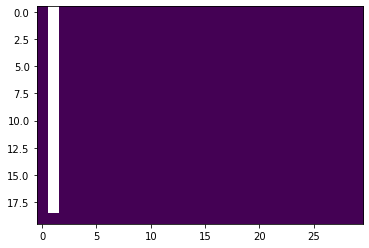

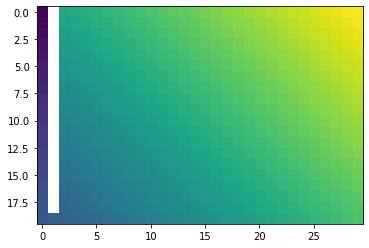

In [8]:
W = np.ones((I,J))

W[:-1, 1] = np.inf

A_weights = weighted_adj_matrix(A, W)

plt.imshow(W)
plt.show()

d, par = dijkstra(A, A_weights, 0)

d_arr = np.array(d).reshape((I,J))
plt.imshow(d_arr)
plt.show()

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599]


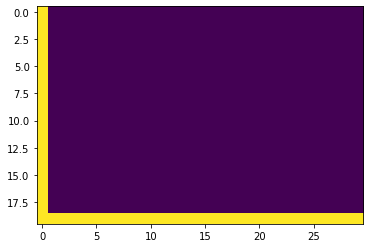

In [9]:
goal_idx = I*J-1
path = []

par_idx = goal_idx
while True:
    
    path.insert(0,  par_idx)
    par_idx = par[par_idx]
    if par_idx == -1:
        break

print(path)

# Convert vertice idx to (i, j) coordinates
i = []
j = []
for path_vert in path:
    i.append( int(path_vert / J) )
    j.append( path_vert % J)

route = np.zeros((I,J))
for idx in range(len(i)):
    route[i[idx], j[idx]] = 1.0

plt.imshow(route)
plt.show()